Importing libraries

In [ ]:
import librosa
import os
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.optim as optim
import cv2
import numpy as np

Accesing GPU

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Loading Dataset

In [ ]:
csv_file_path='/content/drive/MyDrive/archive (24)/TRAIN.csv'
folder_path_train='/content/drive/MyDrive/archive (24)/TRAIN'#audio file folder path


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/archive (24)/TRAIN.csv')

In [ ]:
df

,Filename,Class
0,346.wav,Negative
1,163.wav,Neutral
2,288.wav,Negative
3,279.wav,Negative
4,244.wav,Negative
...,...,...
245,204.wav,Neutral
246,46.wav,Positive
247,318.wav,Negative
248,49.wav,Positive


In [ ]:
#split df into train,test,validation
from sklearn.model_selection import train_test_split
train_df,temp=train_test_split(df,test_size=0.3,random_state=28)
test_df,valid_df=train_test_split(temp,test_size=0.6,random_state=28)

In [ ]:
train_df.shape

(175, 2)

In [ ]:
valid_df.shape

(45, 2)

In [ ]:
test_df.shape

(30, 2)

Audio dataset class

In [ ]:
class AudioDataset(torch.utils.data.Dataset):
  def __init__(self, folder_path, target_sample_rate,csv_file, resize_dim=(15,800)):
    self.csv_file = csv_file
    self.folder_path = folder_path
    self.sample_rate = target_sample_rate
    self.resize_dim =  resize_dim
    self.mapping = {"Positive": [1, 0, 0], "Neutral": [0, 1, 0], "Negative": [0, 0, 1]}

  def __getitem__(self, idx):
    filename = os.path.join(self.folder_path, self.csv_file.iloc[idx, 0])
    audio_data, sr = librosa.load(filename, sr=self.sample_rate)
    audio_data = librosa.feature.melspectrogram(y=audio_data,sr=target_sample_rate,n_fft=400,hop_length=160,n_mels=15)
    audio_data = cv2.resize(audio_data, self.resize_dim)
    audio_data=audio_data.reshape(1,800,15)
    labels = self.csv_file.iloc[idx, 1]
    labels = np.array(self.mapping[labels])

    return audio_data,  labels

  def __len__(self):
    return len(self.csv_file)


In [ ]:
#def collate_fn(batch):
 # audios = []
  #labels = []
  #for audio, label in batch:
   #  audios.append(torch.tensor(audio)) ###
    # labels.append(label)

     #padding of audio list
  #audios=pad_sequence(audios, batch_first=True)
  #convert to tensor
  #audios = np.array(audios)
  #audios = torch.from_numpy(audios)
  #labels=torch.tensor(labels, dtype=torch.float32)
  # labels=labels.shape
  # return them
  #return audios,labels


In [ ]:
target_sample_rate=44100

In [ ]:
train_data=AudioDataset(folder_path_train,44100,train_df)
valid_data=AudioDataset(folder_path_train,44100,valid_df)
test_data=AudioDataset(folder_path_train,44100,test_df)

In [ ]:
print(len(train_data))

175


In [ ]:
print(len(test_data))

30


In [ ]:
train_data[65][0].shape

(1, 800, 15)

Using dataloader for creating batches

In [ ]:
from torch.utils.data import  DataLoader
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=8,shuffle=True, drop_last=True)
valid_dataloader = DataLoader(valid_data, batch_size=8,shuffle=True, drop_last=True)

In [ ]:
len(train_dataloader)

21

In [ ]:
len(valid_dataloader)

5

In [ ]:
len(test_dataloader)

3

In [ ]:
for audios,labels in train_dataloader:
  print(audios.shape, labels.shape)
  break

torch.Size([8, 1, 800, 15]) torch.Size([8, 3])


CNN Model

In [ ]:
class CNNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax

        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=2),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=2),
                                   nn.ReLU(), nn.MaxPool2d(kernel_size=2))

        self.flatten = nn.Flatten()
        shape = self.calculate_shape()
        self.linear = nn.Linear(shape, 3)
        self.softmax = nn.Softmax(dim=1)

    def calculate_shape(self):
        dummy = torch.randn(8,1, 800,15)
        x = self.conv1(dummy)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        #print(type(x))
        x = self.flatten(x)
        return x.shape[1]

    def forward(self, input_data):
        #print(input_data.shape)
        x = self.conv1(input_data)
        #print("Shape after conv1:", x.shape)
        x = self.conv2(x)
        #print("Shape after conv2:", x.shape)
        x = self.conv3(x)
        #print("Shape after conv3:", x.shape)
        x = self.conv4(x)
        #print("Shape after conv4:", x.shape)
        x = self.flatten(x)
        #print("Shape after flattening:",x.shape)

        logits = self.linear(x)
        predictions = self.softmax(logits)
        return predictions

Initialising model

In [ ]:
model=CNNNetwork()

In [ ]:
model.to(device)# moving model to GPU

CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=13056, out_features=3, bias=True)
  (softmax): Softmax(dim=1)
)

In [ ]:
import torch.optim as optim

In [ ]:
#defining Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Training and Validation

In [ ]:
num_epochs = 50
patience = 5  # Number of epochs with no improvement after which training will stop
best_valid_loss = float('inf')
best_model_state = None

train_losses = []  # To store training losses for each epoch
valid_losses = []  # To store validation losses for each epoch

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0.0

    for audios, labels in train_dataloader:
        audios = audios.to(device)
        labels = labels.to(device)
        #audios = audios.reshape(8, 1, 224, 224)
        outputs = model(audios)
        labels = labels.float()
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_dataloader)
    train_losses.append(average_train_loss)

    model.eval()
    total_valid_loss = 0.0

    with torch.no_grad():
        for audios, labels in valid_dataloader:
            audios = audios.to(device)
            labels = labels.to(device)
            #audios = audios.reshape(8, 1, 224, 224)
            outputs = model(audios)
            labels = labels.float()
            loss = criterion(outputs, labels)
            total_valid_loss += loss.item()

    average_valid_loss = total_valid_loss / len(valid_dataloader)
    valid_losses.append(average_valid_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Valid Loss: {average_valid_loss:.4f}')

    # Check for early stopping
    if average_valid_loss < best_valid_loss:
        best_valid_loss = average_valid_loss
        best_model_state = model.state_dict()  # Save the best model state

    # If there is no improvement for 'patience' epochs, stop training
    if epoch - np.argmin(valid_losses) >= patience:
        print(f'Early stopping after {patience} epochs of no improvement.')
        break

# Load the best model state for testing
if best_model_state is not None:
    model.load_state_dict(best_model_state)

Epoch [1/50], Train Loss: 0.9978, Valid Loss: 1.0328
Epoch [2/50], Train Loss: 0.9867, Valid Loss: 1.0732
Epoch [3/50], Train Loss: 0.9790, Valid Loss: 1.0562
Epoch [4/50], Train Loss: 0.9839, Valid Loss: 1.0009
Epoch [5/50], Train Loss: 0.9702, Valid Loss: 1.0306
Epoch [6/50], Train Loss: 0.9695, Valid Loss: 1.1019
Epoch [7/50], Train Loss: 0.9758, Valid Loss: 1.0195
Epoch [8/50], Train Loss: 0.9687, Valid Loss: 1.0358
Epoch [9/50], Train Loss: 0.9726, Valid Loss: 1.0756
Early stopping after 5 epochs of no improvement.


Visualizing the results

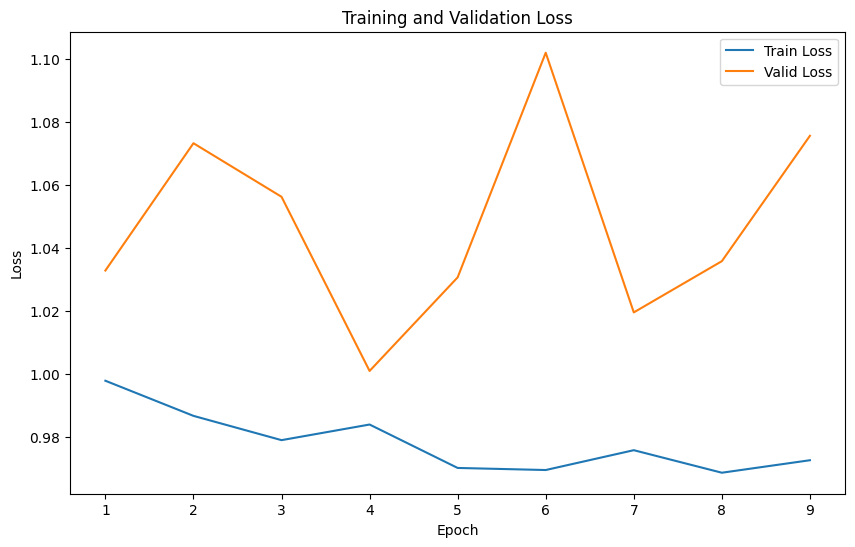

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(valid_losses) + 1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

#Testing

In [ ]:
total_correct = 0
correct=0
total_samples = 0
sample=0

with torch.no_grad():
     for audios, labels in test_dataloader:

        audios = audios.to(device)
        labels = labels.to(device)

        outputs = model(audios)
        threshold = 0.2
        preds = (outputs > threshold).float()
        preds=preds.cpu()

        for i in range(len(labels)):
          labels=labels.cpu()
          if np.argmax(preds[i] == np.argmax(labels[i])):
             correct = correct + 1
          sample=sample+1

          total_samples=sample

# Calculate test accuracy
test_accuracy = correct / sample

print(f'Total Correct Predictions: {correct}')
print(f'Total Samples: {total_samples}')
print(f'Test Accuracy: {test_accuracy*100:.2f}%')

Total Correct Predictions: 15
Total Samples: 24
Test Accuracy: 62.50%
